# Read/write VTK files (Unstructured grid with data)

## Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3d
import vtk
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk

%matplotlib inline

## Create 2-D triangular mesh

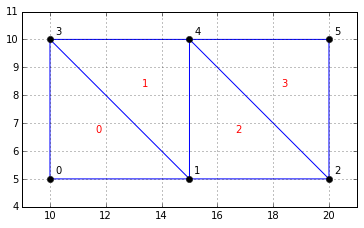

In [2]:
# Create points.
xgrid,ygrid = np.meshgrid([10,15,20], [5,10])
xpoints = xgrid.flatten()
ypoints = ygrid.flatten()
zplanes = [0, 0.5, 1]

# Create triangles.
triangles = np.array(( (0,1,3), (1,4,3), (1,2,4), (2,5,4) ))
ntri = len(triangles)

# Plot points.
plt.plot(xpoints, ypoints, 'ko')
for ipoint,(x,y) in enumerate(zip(xpoints,ypoints)):
    plt.text(x+0.2,y+0.2,'%i'%ipoint)

# Plot triangles.
xtri = np.empty( (ntri) )
ytri = np.empty( (ntri) )
for itri,tri in enumerate(triangles):
    xtri[itri] = sum(xpoints[tri]) / 3.
    ytri[itri] = sum(ypoints[tri]) / 3.
plt.triplot(xpoints, ypoints, triangles)
for itri,(x,y) in enumerate(zip(xtri,ytri)):
    plt.text(x,y,itri,color='red')

# Adjust plot.
plt.axis('scaled')
plt.xlim(9,21)
plt.ylim(4,11)
plt.grid()

## Define 3-D mesh of 8 wedges

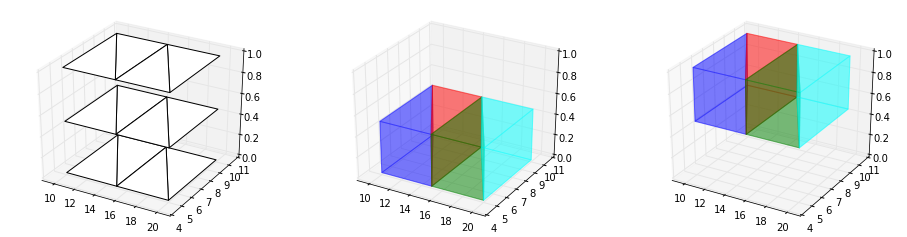

In [8]:
def adjust(ax):
    plt.xlim(9,21)
    plt.ylim(4,11)
    ax.set_zlim(0,1.)
    
def plot_triangles_in_plane(xpoints, ypoints, zplane, triangles):
    zpoints = np.zeros( xpoints.shape )
    zpoints[:] = zplane
    ax.plot_trisurf(xpoints, ypoints, triangles, zpoints, color='w', shade=False)

def plot_wedge(xtrivert, ytrivert, z0, z1, color):
    # First plane triangle points.
    A0 = (xtrivert[0], ytrivert[0], z0)
    B0 = (xtrivert[1], ytrivert[1], z0)
    C0 = (xtrivert[2], ytrivert[2], z0)
    
    # Second plane triangle points.
    A1 = (xtrivert[0], ytrivert[0], z1)
    B1 = (xtrivert[1], ytrivert[1], z1)
    C1 = (xtrivert[2], ytrivert[2], z1)
    
    # Wedge faces.
    bottom = (A0,B0,C0)
    top = (A1,B1,C1)
    side0 = (A0,B0,B1,A1)
    side1 = (B0,C0,C1,B1)
    side2 = (C0,A0,A1,C1)
    faces = (bottom, top, side0, side1, side2)
    
    # Plot wedge.
    wedge = m3d.art3d.Poly3DCollection(faces, alpha=0.3, color=color)
    ax.add_collection3d(wedge)
    
fig = plt.figure(figsize=(16,4))

# Plot triangles in the 3 planes.
nrows,ncols,iplot = 1,3,1
ax = fig.add_subplot(nrows,ncols,iplot, projection='3d')
for zplane in zplanes:
    plot_triangles_in_plane(xpoints, ypoints, zplane, triangles)
adjust(ax)
iplot += 1

# plot wedges
colors = ['blue', 'red', 'green', 'cyan']
for z0,z1 in (zplanes[0:2], zplanes[1:3]):
    ax = fig.add_subplot(nrows,ncols,iplot, projection='3d')
    for itri,color in enumerate(colors):
        plot_wedge(xpoints[triangles[itri]],
                   ypoints[triangles[itri]],
                   z0, z1, color)
    adjust(ax)
    iplot += 1


## Define data on 3-D wedge mesh

## Write 3-D wedges mesh and data to file

In [ ]:
filename = "example.vtk"
writer = vtk.vtkUnstructuredGridWriter()
writer.SetFileName(filename)
grid = vtk.vtkUnstructuredGrid()

In [ ]:
points = vtk.vtkPoints()
points.SetData( numpy_to_vtk(xyzpoints) )
grid.SetPoints(points)

In [ ]:
writer.SetInput(grid)
writer.Write()

In [ ]:
print open('example.vtk').read()

## Read 3-D wedges mesh and data from file

In [ ]:
zip(xpoints, ypoints, zpoints)